# Introducción

## Agrupar Productos Similares en un Marketplace

En un marketplace, como el de Mercado Libre, a menudo nos encontramos con productos similares o idénticos ofrecidos por diferentes vendedores. Esto puede generar confusión en los usuarios al tener que comparar múltiples opciones. 

- El objetivo de este proyecto era desarrollar una solución que permitiera identificar y agrupar estos productos, mejorando así la experiencia del usuarios y hasta posiblemente impactando en la mejora de la gestión de inventarios.

### Investigación y Recopilación de Datos

Para abordar este desafío, el primer paso fue recopilar la mayor cantidad de información posible sobre los productos. USe usó la API de MELI para descargar los títulos e imágenes de los productos de cada categoría, teniendo en cuenta las limitaciones de la API en cuanto a la cantidad de datos que se podían obtener o extraer por solicitud.

- Una de las hipótesis principales era que productos idénticos podían estar listados con distintas escrituras e imágenes, pero con una similaridad muy alta, pero no exactamente igual. Por lo tanto, era crucial obtener información de todas los productos (posibles), para poder identificar y unificarlos.

- Dado que los nombres de los productos pueden variar semánticamente entre países, decidí enfocarme en un solo país para el desarrollo inicial de la solución. Sin embargo, la metodología desarrollada podría aplicarse fácilmente a otros países, simplemente cambiando el índice del país.

- Por último, se identificó que algunos productos podían tener títulos e imágenes muy similares, pero precios totalmente distintos (como el caso de las antiguedades), por lo que integrar un enfoque que diferenciara los productos suficientemente era clave.

### Insights Clave y Solución Propuesta

El análisis exploratorio de los datos reveló varios insights importantes:

1. **Variabilidad en los nombres de productos:** Los nombres de productos similares presentaban una gran variabilidad en su estructura, habiendo explorando esto especialmente en varios países, lo que dificultaba la identificación de coincidencias directas. Para solucionar esto, implementé una limpieza de texto para normalizar los nombres antes de la agrupación. Luego, utilicé TF-IDF y DBSCAN para detectar los clústeres y luego similitudes semánticas en los títulos.

2. **Duplicidad de entidades en diferentes categorías:** Identifiqué que un mismo producto podía aparecer en múltiples categorías, lo que complicaba la organización de los datos. Para abordar esto, propuse un enfoque basado en embeddings semánticos (BERT) para evaluar similitudes entre productos y reubicar aquellos registros que estuvieran incorrectamente categorizados.

3. **Diferencias en precios según la categoría:** Observé que los precios de productos similares podían variar significativamente entre categorías. Para evitar que esto afectara la agrupación, utilicé el coeficiente de variación (CV) para segmentar los precios en rangos bajo, medio y alto (si habia suficiente variabilidad), asegurando que los clusters finales representaran productos similares y con niveles de precio comparables.

### Solución Implementada y Metodología

La solución final se basó en la combinación de técnicas de procesamiento de texto, imágenes y datos cuantitativos:

1. **Procesamiento de texto:**
   - Limpieza y vectorización de datos con TF-IDF.
   - Identificación de clusters con DBSCAN y Random Grid Search, optimizado por Silhouette Score.
   - Comparación de registros dentro de cada clúster utilizando embeddings de BERT y un umbral de 0.985 para reajustes.

2. **Procesamiento de imágenes:**
   - Almacenamiento y vectorización de imágenes con CLIP.
   - Cálculo de similitud coseno entre embeddings de imágenes.
   - Reajuste de clusters si la similitud entre imágenes no superaba 0.90.

3. **Procesamiento cuantitativo:**
   - Segmentación de precios en rangos bajo, medio y alto utilizando el coeficiente de variación y percentiles.
   - Integración de la clasificación de precios con los nombres de los clusters para generar un identificador único.

<img src="https://iili.io/2Q0tRFS.png" alt="Descripción de la imagen" width="40%" />

### Métricas de Evaluación

Para evaluar el rendimiento de la solución, se utilizaron las siguientes métricas:

- Silhouette Score: Para optimizar la agrupación en DBSCAN.
- Similitud Coseno: Para evaluar la coherencia de las asignaciones de texto e imagen.
- Coeficiente de variación (CV): Para la segmentación cuantitativa de precios.

### Resultados y Beneficios

La solución implementada permite unificar entidades similares entre diferentes categorías, mejorando significativamente la precisión en la identificación de productos. Esto se traduce en una mejor experiencia de usuario al facilitar la búsqueda y comparación de productos, así como en una optimización en la gestión del inventario al unificar referencias duplicadas.

El modelo basado en DBSCAN con Random Grid Search optimizado mostró un Silhouette Score alto en todas las etapas. Además, la combinación de similitud de texto (BERT), análisis de imágenes (CLIP) y procesamiento cuantitativo permitió capturar aspectos diferenciadores de un producto como el título, la imagen y el precio.

### Conclusiones y Próximos Pasos

En resumen, la solución desarrollada aborda de manera efectiva el desafío de agrupar productos similares en un marketplace, combinando diversas técnicas de procesamiento de datos y机器学习. Los resultados obtenidos demuestran el potencial de esta solución para mejorar la experiencia del usuario y optimizar la gestión del inventario.

Como próximos pasos, me gustaría:

- Refinar el modelo con datos adicionales, como especificaciones técnicas y métricas de confianza.
- Optimizar el rendimiento en grandes volúmenes de datos mediante indexación y bases de datos vectoriales.
- Validar el impacto de la solución en usuarios y negocio, analizando la reducción de productos duplicados en el inventario.

# 1. Librerías

In [1]:
# ============================================================================
# Importaciones de la biblioteca estándar (Standard Library)
# ============================================================================
import re       # Para el uso de expresiones regulares
import time     # Para funciones relacionadas con tiempos y pausas
import os       # Para manipulación de rutas y archivos del sistema operativo
import pickle   # Para serializar y deserializar objetos en Python
from datetime import datetime # Para manejar fechas

# ============================================================================
# Importaciones de librerías de terceros (Third-party libraries)
# ============================================================================
import requests  # Para realizar solicitudes HTTP
import numpy as np  # Para manejo de arreglos y cálculos numéricos
import pandas as pd  # Para análisis y manipulación de datos tabulares
from tqdm import tqdm  # Para mostrar barras de progreso en iteraciones

# Visualización
import seaborn as sns            # Para gráficas estadísticas con estilo
import matplotlib.pyplot as plt  # Backend de visualización subyacente a Seaborn

# ============================================================================
# Scikit-learn y otras librerías de IA/ML
# ============================================================================
from sklearn.feature_extraction.text import TfidfVectorizer  # Transforma texto a vectores TF-IDF
from sklearn.metrics.pairwise import cosine_similarity       # Calcula similitud de coseno entre vectores
from sklearn.cluster import DBSCAN                           # Clustering basado en densidad (DBSCAN)
from sklearn.metrics import silhouette_score                 # Métrica Silhouette para evaluar clusters

# ============================================================================
# Sentence Transformers
# ============================================================================
from sentence_transformers import SentenceTransformer  # Genera embeddings semánticos de texto

# ============================================================================
# Librerías para obtener tasas de cambio y procesamiento de lenguaje natural
# ============================================================================
import yfinance as yf  # Para consultar datos financieros (incluyendo tasas de cambio)
import nltk            # Para funcionalidades de Procesamiento de Lenguaje Natural (NLP)
from nltk.corpus import stopwords  # Conjunto de palabras vacías (stopwords) en varios idiomas
from nltk.stem.snowball import SpanishStemmer  # Algoritmo de stemming para español

# ============================================================================
# Manejo de imágenes
# ============================================================================
from PIL import Image  # Para abrir y manipular imágenes en diferentes formatos

# 2. Parámetros y objetos

In [2]:
# Lista de países con información más descriptiva de su moneda por defecto y su ID de Mercado Libre.
### Contiene:
# 1. Código de Mercado Libre para El Salvador
# 2. Nombre del país
# 3. Moneda del país

lista_paises_ml = [
    {
        "mercado_libre_id": "MSV",     
        "country_name": "El Salvador", 
        "default_currency": "USD"      # Moneda predeterminada: Dólar estadounidense
    },
    {
        "mercado_libre_id": "MLA",  
        "country_name": "Argentina", 
        "default_currency": "ARS"      # Moneda predeterminada: Peso argentino
    },
    {
        "mercado_libre_id": "MBO",     
        "country_name": "Bolivia", 
        "default_currency": "BOB"      # Moneda predeterminada: Boliviano
    },
    {
        "mercado_libre_id": "MPY",     
        "country_name": "Paraguay", 
        "default_currency": "PYG"      # Moneda predeterminada: Guaraní
    },
    {
        "mercado_libre_id": "MCR",     
        "country_name": "Costa Rica",
        "default_currency": "CRC"      # Moneda predeterminada: Colón costarricense
    },
    {
        "mercado_libre_id": "MHN",     
        "country_name": "Honduras",
        "default_currency": "HNL"      # Moneda predeterminada: Lempira
    },
    {
        "mercado_libre_id": "MLV",     
        "country_name": "Venezuela",
        "default_currency": "VES"      # Moneda predeterminada: Bolívar venezolano
    },
    {
        "mercado_libre_id": "MNI",     
        "country_name": "Nicaragua",
        "default_currency": "NIO"      # Moneda predeterminada: Córdoba
    },
    {
        "mercado_libre_id": "MLB",     
        "country_name": "Brasil",
        "default_currency": "BRL"      # Moneda predeterminada: Real brasileño
    },
    {
        "mercado_libre_id": "MPE",     
        "country_name": "Perú",
        "default_currency": "PEN"      # Moneda predeterminada: Sol
    },
    {
        "mercado_libre_id": "MRD",     
        "country_name": "Dominicana",
        "default_currency": "DOP"      # Moneda predeterminada: Peso dominicano
    },
    {
        "mercado_libre_id": "MPA",     
        "country_name": "Panamá",
        "default_currency": "PAB"      # Moneda predeterminada: Balboa
    },
    {
        "mercado_libre_id": "MCU",     
        "country_name": "Cuba",
        "default_currency": "CUP"      # Moneda predeterminada: Peso cubano
    },
    {
        "mercado_libre_id": "MLC",     
        "country_name": "Chile",
        "default_currency": "CLP"      # Moneda predeterminada: Peso chileno
    },
    {
        "mercado_libre_id": "MGT",     
        "country_name": "Guatemala",
        "default_currency": "GTQ"      # Moneda predeterminada: Quetzal
    },
    {
        "mercado_libre_id": "MEC",     
        "country_name": "Ecuador",
        "default_currency": "USD"      # Moneda predeterminada: Dólar estadounidense
    },
    {
        "mercado_libre_id": "MLU",     
        "country_name": "Uruguay",
        "default_currency": "UYU"      # Moneda predeterminada: Peso uruguayo
    },
    {
        "mercado_libre_id": "MCO",     
        "country_name": "Colombia",
        "default_currency": "COP"      # Moneda predeterminada: Peso colombiano
    },
    {
        "mercado_libre_id": "MLM",     
        "country_name": "Mexico",
        "default_currency": "MXN"      # Moneda predeterminada: Peso mexicano
    }
]


In [3]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stopwords_totales = stopwords_es.union(stopwords_en)

# 3. Importación

In [4]:
def obtener_respuesta_api(url: str, max_intentos: int = 3) -> dict:
    """
    Realiza una solicitud GET a la API con un mecanismo de reintentos y retorna la respuesta en formato JSON.
    """
    session = requests.Session()
    intentos = 0

    while intentos < max_intentos:
        try:
            response = session.get(url)
            if response.status_code == 200:
                return response.json()
            elif response.status_code == 403:
                # Bloqueos temporales, por ejemplo, rate limit
                time.sleep(10 * (intentos + 1))
                intentos += 1
            else:
                print(f"Error {response.status_code} al consultar API: {url}")
                break
        except requests.RequestException as e:
            print(f"Excepción al hacer la solicitud: {e}")
            time.sleep(5 * (intentos + 1))
            intentos += 1

    return None

def consultar_categorias_pais(codigo_pais: str, max_intentos: int = 2) -> list:
    """
    Consulta las categorías de un país en la API de Mercado Libre y las retorna como una lista de categorías.
    """
    categorias_url = f"https://api.mercadolibre.com/sites/{codigo_pais}/categories"
    categorias_list = obtener_respuesta_api(categorias_url, max_intentos=max_intentos)

    if not categorias_list:
        return []

    return categorias_list

def procesar_productos(
    data: list,
    codigo_categoria: str,
    nombre_categoria: str,
    codigo_moneda: str
) -> list:
    """
    Agrega metadatos (categoría y moneda) a cada producto obtenido.
    """
    productos_procesados = []
    for item in data:
        item["category_id"] = codigo_categoria
        item["category_name"] = nombre_categoria
        item["currency_code"] = codigo_moneda
        productos_procesados.append(item)

    return productos_procesados

def consultar_productos(
    codigo_pais: str,
    codigo_categoria: str,
    nombre_categoria: str,
    codigo_moneda: str,
    limite_consulta: int = 100000,
    offset: int = 10,
    max_intentos: int = 2
) -> pd.DataFrame:
    """
    Consulta los productos de una categoría en la API de Mercado Libre y los retorna en un DataFrame.
    """
    url_base = f"https://api.mercadolibre.com/sites/{codigo_pais}/search"
    todos_los_items = []

    for numero_offset in range(0, limite_consulta, offset):
        url = f"{url_base}?category={codigo_categoria}&offset={numero_offset}"

        data = obtener_respuesta_api(url, max_intentos=max_intentos)
        if not data or not data.get("results"):
            break

        productos = procesar_productos(
            data["results"],
            codigo_categoria,
            nombre_categoria,
            codigo_moneda
        )
        todos_los_items.extend(productos)

        total_en_api = data.get("paging", {}).get("total", 0)
        if numero_offset + offset >= total_en_api:
            break

    return pd.DataFrame(todos_los_items)

def extraer_productos_por_pais_y_categoria(pais_metadata: dict) -> pd.DataFrame:
    """
    Extrae los productos para un país según sus categorías y retorna
    la información en un DataFrame consolidado.
    """
    pais_codigo = pais_metadata["mercado_libre_id"]
    moneda_codigo = pais_metadata["default_currency"]
    pais_nombre = pais_metadata["country_name"]

    categorias_lista = consultar_categorias_pais(codigo_pais=pais_codigo, max_intentos=2)

    resultados_por_categoria = []
    for categoria in tqdm(
        categorias_lista,
        desc=f"Obteniendo productos por categoría para {pais_nombre}",
        unit="Categoría",
        leave=True,
        dynamic_ncols=True
    ):
        categoria_codigo = categoria["id"]
        categoria_nombre = categoria["name"]

        try:
            productos_df = consultar_productos(
                codigo_pais=pais_codigo,
                codigo_categoria=categoria_codigo,
                nombre_categoria=categoria_nombre,
                codigo_moneda=moneda_codigo,
                limite_consulta=100000,
                offset=10,
                max_intentos=2
            )
            resultados_por_categoria.append(productos_df)
        except Exception as e:
            print(f"Error al procesar la categoría {categoria_nombre}: {e}")
            continue

    if resultados_por_categoria:
        return pd.concat(resultados_por_categoria, ignore_index=True)
    else:
        return pd.DataFrame()  # Retorna un DataFrame vacío si no hay resultados

def guardar_datos(pais_metadata: dict, df: pd.DataFrame):
    """
    Guarda el DataFrame en un archivo CSV en el directorio especificado.
    """
    mercado_libre_id = pais_metadata["mercado_libre_id"]
    fecha_hoy = datetime.now().strftime("%Y-%m-%d")
    nombre_archivo = f"products_data_{fecha_hoy}.csv"
    directorio_pais = os.path.join("countries_data", "products", mercado_libre_id)
    
    # Crear el directorio si no existe
    os.makedirs(directorio_pais, exist_ok=True)
    
    ruta_archivo = os.path.join(directorio_pais, nombre_archivo)
    
    if os.path.exists(ruta_archivo):
        print(f"El archivo {ruta_archivo} ya existe. No se realizará la extracción.")
    else:
        if not df.empty:
            df.to_csv(ruta_archivo, index=False)
            print(f"Datos guardados exitosamente en {ruta_archivo}")
        else:
            print(f"No hay datos para guardar para el país {mercado_libre_id} en la fecha {fecha_hoy}.")

def cargar_datos_existentes(pais_metadata: dict) -> pd.DataFrame:
    """
    Carga el archivo CSV existente para el país y la fecha actual.
    """
    mercado_libre_id = pais_metadata["mercado_libre_id"]
    fecha_hoy = datetime.now().strftime("%Y-%m-%d")
    nombre_archivo = f"products_data_{fecha_hoy}.csv"
    directorio_pais = os.path.join("countries_data", "products", mercado_libre_id)
    ruta_archivo = os.path.join(directorio_pais, nombre_archivo)
    
    if os.path.exists(ruta_archivo):
        print(f"Cargando datos existentes desde {ruta_archivo}")
        return pd.read_csv(ruta_archivo)
    else:
        print(f"No existe el archivo {ruta_archivo}. Será necesario extraer los datos.")
        return pd.DataFrame()  # Retorna un DataFrame vacío si no existe el archivo

def extraccion_guardado_pais(pais_metadata: dict):
    """
    Función principal que coordina la extracción y el guardado de datos para una lista de países.
    
    Args:
        paises_metadata (list): Lista de diccionarios con metadata de cada país.
    """

    mercado_libre_id = pais_metadata["mercado_libre_id"]
    if not mercado_libre_id:
        print("No se encontró 'mercado_libre_id' en la metadata del país. Saltando...")
        
    # Definir la ruta del archivo para verificar existencia
    fecha_hoy = datetime.now().strftime("%Y-%m-%d")
    nombre_archivo = f"products_data_{fecha_hoy}.csv"
    directorio_pais = os.path.join("countries_data", "products", mercado_libre_id)
    ruta_archivo = os.path.join(directorio_pais, nombre_archivo)
    
    if os.path.exists(ruta_archivo):
        print(f"El archivo para {mercado_libre_id} en la fecha {fecha_hoy} ya existe. Cargando el archivo existente.")
        df = pd.read_csv(ruta_archivo)

        return df
    else:
        print(f"Extrayendo datos para el país: {mercado_libre_id}")
        df = extraer_productos_por_pais_y_categoria(pais_metadata)
        guardar_datos(pais_metadata, df)

        return df    

In [5]:
print("Metadata de un país específico:")
metadata_pais_especifico = lista_paises_ml[17]
metadata_pais_especifico

Metadata de un país específico:


{'mercado_libre_id': 'MCO',
 'country_name': 'Colombia',
 'default_currency': 'COP'}

In [6]:
df_pais = extraccion_guardado_pais(pais_metadata = metadata_pais_especifico)

El archivo para MCO en la fecha 2025-01-29 ya existe. Cargando el archivo existente.


C:\Users\Admin\AppData\Local\Temp\ipykernel_74596\229223616.py:195: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


# 4. Análisis Exploratorio de Datos

In [7]:
def limpiar_texto(texto):
    """
    Limpia y formatea un texto:
    - Convierte a minúsculas
    - Elimina espacios adicionales al inicio, final y entre palabras
    - Quita caracteres especiales, pero conserva acentos y caracteres en español
    - Devuelve el texto en formato título (Title Case)

    Args:
        texto (str): El texto a limpiar.

    Returns:
        str: Texto limpio y formateado.
    """
    if texto:
        # Convertir a minúsculas
        texto = texto.lower()
        
        # Quitar caracteres especiales excepto letras, números y caracteres españoles
        texto = re.sub(r'[^a-záéíóúüñ0-9\s]', ' ', texto, flags=re.IGNORECASE)
        
        # Eliminar espacios adicionales
        texto = re.sub(r'\s+', ' ', texto).strip()
        
        # Convertir a formato título
        texto = texto.title()
    
    return texto

In [8]:
df_pais["condition_cleaned"] = df_pais["condition"].fillna("None").apply(limpiar_texto).str.replace("Not Specified", "None")

In [9]:
def contar_absolutos_y_relativos(df: pd.DataFrame, columna: str) -> pd.DataFrame:
    """
    Genera un DataFrame con las frecuencias absolutas y relativas (porcentaje) 
    de los valores en una columna específica de un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame de origen.
        columna (str): Nombre de la columna del DataFrame sobre la que se desea realizar el conteo.
        
    Returns:
        pd.DataFrame: DataFrame con tres columnas:
                      - 'Valor': Valor encontrado en la columna original.
                      - 'Frecuencia': Conteo absoluto de cada valor.
                      - 'Porcentaje': Porcentaje que representa cada valor respecto al total.
    """
    # Conteo absoluto
    conteo_abs = df[columna].value_counts(dropna=False)
    
    # Conteo relativo (proporción, luego se multiplica por 100 para porcentaje)
    conteo_rel = df[columna].value_counts(dropna=False, normalize=True) * 100
    
    # Crear un nuevo DataFrame con los resultados
    resultados = pd.DataFrame({
        'Valor': conteo_abs.index,
        'Frecuencia': conteo_abs.values,
        'Porcentaje': conteo_rel.values
    })
    
    # Opcional: ordenar por frecuencia descendente
    resultados.sort_values(by='Frecuencia', ascending=False, inplace=True, ignore_index=True)
    
    return resultados

In [10]:
contar_absolutos_y_relativos(df = df_pais, columna = 'condition_cleaned') 

,Valor,Frecuencia,Porcentaje
0,New,137028,90.354486
1,Used,9441,6.225273
2,None,5187,3.420241


In [11]:
df_pais["domain_id_cleaned"] = df_pais["domain_id"].fillna("None").apply(limpiar_texto).str.replace("Not Specified", "None").str.replace("Mgt ", "")

In [12]:
contar_absolutos_y_relativos(df = df_pais, columna = 'domain_id_cleaned').head(20)

,Valor,Frecuencia,Porcentaje
0,Mco Books,5002,3.298254
1,Mco Cars And Vans,4771,3.145936
2,Mco Music Albums,4030,2.657330
3,Mco Wristwatches,3851,2.539299
4,Mco Cellphones,2831,1.866725
5,Mco Supplements,2786,1.837052
6,Mco Headphones,2612,1.722319
7,Mco Other Services,2411,1.589782
8,Mco Game Consoles,2072,1.366250
9,Mco Candies,1899,1.252176


In [13]:
def eliminar_atipicos_iqr(df: pd.DataFrame, columna: str, factor: float = 1.5) -> pd.DataFrame:
    """
    Elimina los valores atípicos de una columna numérica de un DataFrame 
    utilizando la regla IQR (Interquartile Range).
    
    Args:
        df (pd.DataFrame): DataFrame de origen.
        columna (str): Nombre de la columna a filtrar.
        factor (float): Factor para multiplicar el IQR (por defecto 1.5). 
                        Un valor mayor implica filtrar menos datos como atípicos.

    Returns:
        pd.DataFrame: DataFrame sin los registros considerados atípicos.
    """
    # Calcular cuartiles y rango intercuartílico
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1

    # Límites inferior y superior para filtrar atípicos
    limite_inferior = q1 - factor * iqr
    limite_superior = q3 + factor * iqr

    # Filtrar el DataFrame para excluir valores atípicos
    df_filtrado = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

    return df_filtrado

def graficar_distribucion_kde(df: pd.DataFrame, columna: str, factor_iqr: float = 1.5) -> None:
    """
    Grafica la distribución de una columna numérica usando un KDE (Kernel Density Estimate),
    excluyendo los valores atípicos determinados por la regla IQR.
    
    Args:
        df (pd.DataFrame): DataFrame de origen.
        columna (str): Nombre de la columna que se desea analizar.
        factor_iqr (float): Factor para multiplicar el IQR (por defecto 1.5).
    """
    # Eliminar valores atípicos
    df_sin_atipicos = eliminar_atipicos_iqr(df, columna, factor_iqr)

    # Crear la figura y el eje
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df_sin_atipicos, x=columna, fill=True)
    plt.title(f"Distribución KDE de '{columna}' (sin atípicos)")
    plt.xlabel(columna)
    plt.ylabel("Densidad")
    plt.show()

def graficar_caja_bigotes(df: pd.DataFrame, columna: str, factor_iqr: float = 1.5) -> None:
    """
    Grafica un boxplot de una columna numérica, excluyendo los valores atípicos
    determinados por la regla IQR.
    
    Args:
        df (pd.DataFrame): DataFrame de origen.
        columna (str): Nombre de la columna que se desea graficar.
        factor_iqr (float): Factor para multiplicar el IQR (por defecto 1.5).
    """
    # Eliminar valores atípicos
    df_sin_atipicos = eliminar_atipicos_iqr(df, columna, factor_iqr)

    # Crear la figura y el eje
    plt.figure(figsize=(4, 6))
    sns.boxplot(data=df_sin_atipicos, y=columna)
    plt.title(f"Boxplot de '{columna}' (sin atípicos)")
    plt.ylabel(columna)
    plt.show()

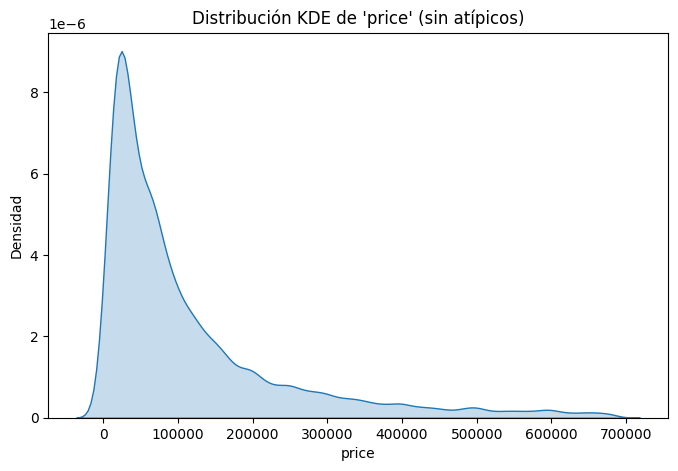

In [14]:
# Supongamos que 'df_pais' es el DataFrame resultante que incluye la columna "price".
# Para graficar la distribución (KDE) sin atípicos:
graficar_distribucion_kde(df_pais, "price", factor_iqr=1.5)

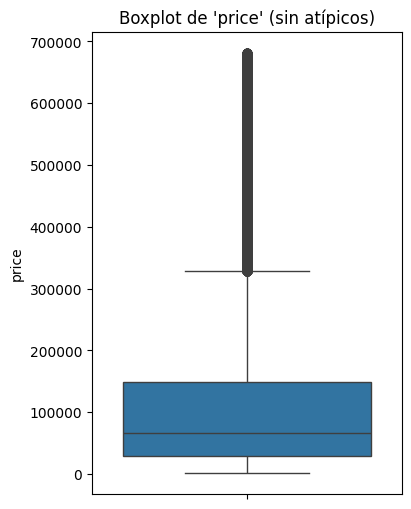

In [15]:
# Para graficar el boxplot (caja y bigotes) sin atípicos:
graficar_caja_bigotes(df_pais, "price", factor_iqr=1.5)

In [16]:
contar_absolutos_y_relativos(df = df_pais, columna = 'accepts_mercadopago')

,Valor,Frecuencia,Porcentaje
0,True,136558,90.044575
1,False,15098,9.955425


In [17]:
# Ejemplo: Extraer 'store_pick_up' y 'free_shipping' de la columna "shipping"
df_pais["store_pick_up"] = df_pais["shipping"].apply(lambda x: x.get("store_pick_up") if isinstance(x, dict) else None)
df_pais["free_shipping"] = df_pais["shipping"].apply(lambda x: x.get("free_shipping") if isinstance(x, dict) else None)


In [18]:
def obtener_tasa_usd_a_moneda(codigo_moneda: str) -> float:
    """
    Intenta obtener cuántas unidades de 'codigo_moneda' equivalen a 1 USD
    usando el ticker 'USD{moneda}=X' en Yahoo Finance.
    
    Ejemplo: codigo_moneda='ARS' -> Ticker='USDARS=X'
             Retorna un float con el cierre más reciente.
    """
    if codigo_moneda.upper() == "USD":
        return 1.0  # USD a USD es siempre 1
    
    ticker_symbol = f"USD{codigo_moneda.upper()}=X"
    ticker = yf.Ticker(ticker_symbol)
    
    try:
        hist = ticker.history(period="1d")  # Pedimos el histórico de 1 día
        if hist.empty:
            # Yahoo no reconoce el ticker o no hay datos
            return None
        
        # Tomamos el valor de cierre más reciente
        tasa = hist["Close"].iloc[-1]
        return float(tasa)
    except Exception as e:
        # Cualquier problema (ticker no existe, error de conexión, etc.)
        print(f"No se pudo obtener la tasa para {codigo_moneda}: {e}")
        return None

In [19]:
def crear_tabla_equivalencias_en_dolares_yahoo(lista_paises_ml: list) -> pd.DataFrame:
    """
    Crea una tabla de equivalencias para convertir de la moneda local a USD 
    utilizando la librería yfinance (Yahoo! Finance), sin necesidad de API key.
    
    Args:
        lista_paises_ml (list): Lista de diccionarios que contienen al menos:
                                - 'default_currency': código de la moneda local.
    
    Returns:
        pd.DataFrame: Con columnas:
                      - 'currency': Moneda local (p. ej., 'ARS')
                      - 'usd_per_1_local': Cuántos USD equivale 1 unidad de esa moneda (si está disponible).
                      - 'local_per_1_usd': Cuántos de esa moneda equivale 1 USD (si está disponible).
    """
    # Extraemos las monedas únicas
    monedas_unicas = list({pais["default_currency"].upper() for pais in lista_paises_ml})
    
    data_equivalencias = []
    
    for moneda in monedas_unicas:
        # Obtener cuántas monedas local = 1 USD
        # (por ejemplo, si USDARS=X cierra en 300, 1 USD = 300 ARS)
        # -> 1 ARS = (1/300) USD
        tasa_usd_en_moneda_local = obtener_tasa_usd_a_moneda(moneda)
        
        if tasa_usd_en_moneda_local is not None and tasa_usd_en_moneda_local > 0:
            # 1 moneda local = 1 / tasa_usd_en_moneda_local USD
            usd_por_moneda_local = 1 / tasa_usd_en_moneda_local
        else:
            usd_por_moneda_local = None
        
        data_equivalencias.append({
            "currency": moneda,
            "local_per_1_usd": tasa_usd_en_moneda_local,  # Cuántas monedas = 1 USD
            "usd_per_1_local": usd_por_moneda_local       # Cuántos USD = 1 moneda local
        })
    
    df_equivalencias = pd.DataFrame(data_equivalencias)
    return df_equivalencias

In [20]:
df_equivalencias = crear_tabla_equivalencias_en_dolares_yahoo(lista_paises_ml)
print(df_equivalencias)

   currency  local_per_1_usd  usd_per_1_local
0       ARS      1051.000000         0.000951
1       DOP        61.590000         0.016236
2       NIO        36.624298         0.027304
3       MXN        20.499451         0.048782
4       HNL        25.469900         0.039262
5       VES        57.154202         0.017497
6       CRC       504.329987         0.001983
7       BRL         5.869300         0.170378
8       PYG      7891.509766         0.000127
9       PEN         3.713700         0.269273
10      PAB         1.000000         1.000000
11      CLP       989.929993         0.001010
12      USD         1.000000         1.000000
13      GTQ         7.731000         0.129349
14      CUP        24.000000         0.041667
15      COP      4167.000000         0.000240
16      BOB         6.850000         0.145985
17      UYU        43.368000         0.023058


In [21]:
df_pais_extended = pd.merge(df_pais, df_equivalencias, 
                     left_on="currency_code", right_on="currency",
                     how="left")

df_pais_extended["price_usd"] = df_pais_extended["price"] * df_pais_extended["usd_per_1_local"]

In [22]:
def limpiar_texto_extendido(texto: str) -> str:
    """
    Limpia y formatea el texto con los siguientes pasos:
      1. Convierte a minúsculas.
      2. Elimina caracteres no alfanuméricos (exceptuando acentos, eñes y espacios).
      3. Elimina espacios sobrantes.
      4. Tokeniza la frase (separa en palabras).
      5. Quita stopwords en español e inglés.
      6. Aplica stemming en español a cada palabra.
      7. Retorna el resultado en Title Case.

    Args:
        texto (str): Texto de entrada.

    Returns:
        str: Texto procesado, sin caracteres extraños, sin stopwords
             (en español e inglés) y con las palabras stemmizadas en español.
    """
    if not texto:
        return ""

    # 1) Convertir a minúsculas
    texto = texto.lower()

    # 2) Eliminar caracteres especiales (excepto acentos, eñes, dígitos y espacios)
    texto = re.sub(r"[^a-záéíóúüñ0-9\s]", " ", texto, flags=re.IGNORECASE)

    # 3) Eliminar espacios adicionales
    texto = re.sub(r"\s+", " ", texto).strip()

    # 4) Tokenizar
    tokens = texto.split()  # Separación por espacios

    # 5) Remover stopwords (ES + EN)
    tokens_filtrados = [t for t in tokens if t not in stopwords_totales]

    # Unimos tokens y aplicamos Title Case
    texto_resultante = " ".join(tokens_filtrados).title()

    return texto_resultante


In [23]:
def limpiar_y_transformar_df_pais(df_pais: pd.DataFrame, lista_paises_ml: list) -> pd.DataFrame:
    """
    Aplica en 'df_pais' los pasos de limpieza y transformación, 
    SIN definir las funciones que ya existen en el entorno:
      1) Rellena nulos y limpia texto en 'condition', 'title', 'domain_id'
         (reemplaza 'Not Specified' por 'None', elimina 'Mgt ' en 'domain_id').
      2) Extrae 'store_pick_up' y 'free_shipping' de la columna 'shipping'.
      3) Obtiene la tabla de equivalencias de moneda a USD con 'crear_tabla_equivalencias_en_dolares_yahoo'.
      4) Realiza un merge para añadir la tasa de conversión.
      5) Calcula 'price_usd'.

    Se asume que las siguientes funciones ya existen en el entorno:
      - limpiar_texto
      - crear_tabla_equivalencias_en_dolares_yahoo

    Args:
        df_pais (pd.DataFrame): DataFrame con las columnas 'condition', 'title', 'domain_id',
                                'shipping', 'price', 'currency_code'.
        lista_paises_ml (list): Lista de dicts con la llave 'default_currency' 
                                para construir la tabla de equivalencias.

    Returns:
        pd.DataFrame: El DataFrame transformado, con las nuevas columnas agregadas.
    """

    # 1) Crear columnas limpias
    df_pais["condition_cleaned"] = (
        df_pais["condition"]
        .fillna("None")
        .apply(limpiar_texto)
        .str.replace("Not Specified", "None", regex=False)
    )

    df_pais["title_sanitized"] = (
        df_pais["title"]
        .apply(limpiar_texto)
        .str.replace("Not Specified", "None", regex=False)
    )

    df_pais["title_cleaned"] = (
        df_pais["title"]
        .apply(limpiar_texto_extendido)
        .str.replace("Not Specified", "None", regex=False)
    )

    df_pais["domain_id_cleaned"] = (
        df_pais["domain_id"]
        .fillna("None")
        .apply(limpiar_texto)
        .str.replace("Not Specified", "None", regex=False)
        .str.replace("Mgt ", "", regex=False)
    )

    # 2) Extraer 'store_pick_up' y 'free_shipping' de la columna "shipping"
    df_pais["store_pick_up"] = df_pais["shipping"].apply(
        lambda x: x.get("store_pick_up") if isinstance(x, dict) else None
    )
    df_pais["free_shipping"] = df_pais["shipping"].apply(
        lambda x: x.get("free_shipping") if isinstance(x, dict) else None
    )

    # 3) Obtener la tabla de equivalencias a USD (se asume la función existe)
    df_equivalencias = crear_tabla_equivalencias_en_dolares_yahoo(lista_paises_ml)

    # 4) Realizar el merge para agregar la equivalencia a USD
    df_pais_extended = pd.merge(
        df_pais,
        df_equivalencias,
        left_on="currency_code",
        right_on="currency",
        how="left"
    )

    # 5) Calcular 'price_usd'
    df_pais_extended["price_usd"] = (
        df_pais_extended["price"] * df_pais_extended["usd_per_1_local"]
    )

    return df_pais_extended

In [24]:
df_pais_cleaned = limpiar_y_transformar_df_pais(df_pais = df_pais,
                                                lista_paises_ml = lista_paises_ml)

# 5. Modelos

## 5.1. Modelos: Similaridad en texto

In [25]:
def generar_clusters_y_calcular_similitud(
    df: pd.DataFrame,
    texto_col: str = "title_cleaned",
    eps_inicio: float = 0.05,
    eps_fin: float = 0.5,
    num_pasos: int = 10,
    modelo_sentence_transformers: str = "paraphrase-MiniLM-L6-v2",
    new_cluster_name: str = "cluster_name"
) -> pd.DataFrame:
    """
    Genera clústeres usando DBSCAN sobre vectores TF-IDF, selecciona el mejor 'eps'
    según Silhouette Score, asigna nombres a cada clúster y calcula la similitud
    entre el texto de cada registro y el texto representativo de su propio clúster
    usando embeddings de sentence-transformers. Asimismo, se añaden métricas de
    precio relacionadas con cada clúster (promedio, diferencia, porcentaje).

    Pasos:
        1. Crear una copia del DataFrame para no modificar el original.
        2. Vectorizar el texto (columna 'texto_col') con TF-IDF.
        3. Calcular la matriz de similitudes de coseno.
        4. Convertir la similitud en distancia (dist = 1 - sim).
        5. Realizar grid search de 'eps' en un rango determinado, usando
           Silhouette Score para elegir el mejor resultado.
        6. Asignar etiquetas de clúster al DataFrame y nombrar cada clúster
           con el texto más largo.
        7. Calcular embeddings (sentence-transformers) del título y el nombre
           de su clúster, y añadir la columna de similitud.
        8. Ajustar el cluster_name si la similitud es < 0.985, poniendo el
           título original.
        9. Calcular métricas de precio en USD para cada clúster:
           - price_usd_mean: promedio de precio en USD por clúster
           - cluster_count: conteo de registros en el clúster
           - price_usd_diff: diferencia entre el precio y el promedio del clúster
           - price_usd_diff_perc: diferencia porcentual respecto al promedio

    Args:
        df (pd.DataFrame):
            DataFrame original que contiene la columna de texto a clusterizar
            y columnas de precios.
        texto_col (str):
            Nombre de la columna de texto limpio. Por defecto, "title_cleaned".
        eps_inicio (float):
            Valor inicial de 'eps' en la búsqueda de DBSCAN. Por defecto, 0.05.
        eps_fin (float):
            Valor final de 'eps' en la búsqueda de DBSCAN. Por defecto, 0.5.
        num_pasos (int):
            Número de valores de 'eps' a generar entre eps_inicio y eps_fin.
            Por defecto, 10.
        modelo_sentence_transformers (str):
            Nombre del modelo a cargar de 'sentence_transformers'. Por defecto,
            'paraphrase-MiniLM-L6-v2'.

    Returns:
        pd.DataFrame:
            El DataFrame copiado y modificado
    """

    # 1. Crear una copia para no modificar el DataFrame original
    df_copy = df.copy(deep=True)

    # 2. Vectorizar el texto con TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_copy[texto_col])

    # 3. Calcular similitud de coseno
    similitudes = cosine_similarity(X)

    # 4. Convertir similitud en distancia
    distancias = 1 - similitudes
    distancias = np.clip(distancias, 0, None)
    np.fill_diagonal(distancias, 0)

    # 5. Grid Search para DBSCAN (métrica "precomputed")
    eps_values = np.round(np.linspace(eps_inicio, eps_fin, num_pasos), 2)
    best_eps = None
    best_score = -1
    best_clusters = None

    for eps in tqdm(eps_values,
                         desc="Probando modelos",
                         total=len(eps_values),
                         unit="values"):
        
        clustering = DBSCAN(metric="precomputed", eps=eps, min_samples=2)
        labels = clustering.fit_predict(distancias)

        # Ignorar configuraciones sin clústeres válidos (solo 1 etiqueta)
        if len(set(labels)) > 1:
            score = silhouette_score(distancias, labels, metric="precomputed")
            if score > best_score:
                best_score = score
                best_eps = eps
                best_clusters = labels

    # Asignar el mejor resultado; si no se encontró, todo se marca como -1
    df_copy["cluster"] = best_clusters if best_clusters is not None else -1

    # 6. Nombrar cada clúster con el texto más largo
    df_copy[new_cluster_name] = df_copy.groupby("cluster")[texto_col].transform(
        lambda x: x.loc[x.str.len().idxmax()]
    )
    df_copy.loc[df_copy["cluster"] == -1, new_cluster_name] = df_copy[texto_col]

    # 7. Calcular embeddings y similitud
    model = SentenceTransformer(modelo_sentence_transformers)
    embeddings_title = model.encode(df_copy[texto_col].tolist())
    embeddings_cluster = model.encode(df_copy[new_cluster_name].tolist())

    similitudes_fila = []
    for i in range(len(df_copy)):
        sim = cosine_similarity([embeddings_title[i]], [embeddings_cluster[i]])[0][0]
        similitudes_fila.append(sim)
    df_copy["similarity"] = similitudes_fila

    # 8. Ajustar cluster_name si la similitud es < 0.985
    df_copy.loc[df_copy["similarity"] < 0.985, new_cluster_name] = df_copy.loc[
        df_copy["similarity"] < 0.985, texto_col
    ]

    # Mostrar un log del mejor resultado
    if best_clusters is not None:
        print(f"\nMejor eps: {best_eps} con Silhouette Score: {best_score}")
    else:
        print(
            "No se encontró un eps óptimo (todos los clusters resultaron en una sola etiqueta)."
        )

    # 9. Calcular estadísticas de precio en USD
    df_copy["price_usd_mean"] = df_copy.groupby(new_cluster_name)["price_usd"].transform(
        "mean"
    )
    df_copy["cluster_count"] = df_copy.groupby(new_cluster_name)["price_usd"].transform(
        "count"
    )
    df_copy["price_usd_diff"] = df_copy["price_usd"] - df_copy["price_usd_mean"]
    df_copy["price_usd_diff_perc"] = (
        (df_copy["price_usd"] / df_copy["price_usd_mean"] - 1) * 100
    ).round(6)

    return df_copy


In [ ]:
df_pais_cleaned_ext = generar_clusters_y_calcular_similitud(
    df = df_pais_cleaned,
    texto_col="title_cleaned",
    eps_inicio=0.05,
    eps_fin=0.5,
    num_pasos=10,
    modelo_sentence_transformers="paraphrase-MiniLM-L6-v2"
)

In [26]:
def cargar_embedding(ruta_imagen: str) -> np.ndarray:
    """
    Carga un embedding en formato .emb.pkl a partir de la ruta de una imagen.
    Si el archivo no existe o ocurre un error, retorna None.

    Args:
        ruta_imagen (str): Ruta completa a la imagen sin la extensión .emb.pkl.

    Returns:
        np.ndarray or None: Vector embedding cargado desde el pickle, 
                            o None si no se pudo cargar.
    """
    if not ruta_imagen:
        return None
    
    # Construimos la ruta al archivo .emb.pkl
    embedding_path = ruta_imagen + ".emb.pkl"
    
    if not os.path.exists(embedding_path):
        return None
    
    try:
        with open(embedding_path, "rb") as f:
            emb = pickle.load(f)
        return emb
    except Exception as e:
        print(f"Error cargando {embedding_path}: {e}")
        return None

def calcular_similitud_fila(row: pd.Series,
                            col1: str = "image_path",
                            col2: str = "cluster_img_name") -> float:
    """
    Toma la información de una fila (serie de pandas), carga los embeddings 
    de las dos columnas especificadas y calcula la similitud de coseno.

    Args:
        row (pd.Series): Una fila de DataFrame (el registro actual).
        col1 (str): Nombre de la columna que contiene la ruta de la primera imagen.
        col2 (str): Nombre de la columna que contiene la ruta de la segunda imagen.

    Returns:
        float: Similitud de coseno entre los embeddings, o NaN si falla.
    """
    ruta1 = row.get(col1, "")
    ruta2 = row.get(col2, "")
    
    emb1 = cargar_embedding(ruta1)
    emb2 = cargar_embedding(ruta2)
    
    # Verificamos si ambos embeddings se pudieron cargar
    if emb1 is None or emb2 is None:
        return np.nan  # No se pudo calcular

    # Reshape para usar sklearn.metrics.pairwise.cosine_similarity
    emb1_2d = emb1.reshape(1, -1)
    emb2_2d = emb2.reshape(1, -1)
    
    sim = cosine_similarity(emb1_2d, emb2_2d)[0][0]
    return sim

def comparar_embeddings(df: pd.DataFrame,
                        col_image: str = "image_path",
                        col_cluster: str = "cluster_img_name") -> pd.DataFrame:
    """
    Para cada fila, carga los embeddings correspondientes a col_image y col_cluster,
    y calcula la similitud de coseno. Agrega una nueva columna 'similarity_emb'.

    Args:
        df (pd.DataFrame): DataFrame con las columnas col_image y col_cluster.
        col_image (str): Columna donde está la ruta de la primera imagen.
        col_cluster (str): Columna donde está la ruta de la segunda imagen.

    Returns:
        pd.DataFrame: Mismo DataFrame con una columna adicional 'similarity_emb'.
    """
    df_copy = df.copy(deep=True)
    
    # Aplicamos la función de similitud fila a fila
    df_copy["similarity_img"] = df_copy.apply(
        lambda row: calcular_similitud_fila(row, col1=col_image, col2=col_cluster), 
        axis=1
    )
    return df_copy

def descargar_imagen(url: str, output_folder: str) -> str:
    """
    Descarga la imagen desde 'url' y la guarda en 'output_folder',
    retornando la ruta local donde se almacenó.
    Si el archivo ya existe, no se descarga de nuevo.
    """
    try:
        filename = os.path.join(output_folder, os.path.basename(url))
        if not os.path.exists(filename):
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(filename, "wb") as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
            else:
                return None
        return filename
    except Exception:
        return None


def generar_clusters_imagenes(
    df: pd.DataFrame,
    url_col: str = "thumbnail",
    country_col: str = "country_name",
    output_folder: str = "imagenes_descargadas",
    model_name: str = "clip-ViT-B-32",
    eps_inicio: float = 0.05,
    eps_fin: float = 0.5,
    num_pasos: int = 10
) -> pd.DataFrame:
    """
    Toma los enlaces de imágenes (columna 'url_col'), y el nombre de país (columna 'country_col'),
    genera subcarpetas para cada país en 'output_folder', descarga las imágenes allí y
    posteriormente genera embeddings con 'model_name' (por defecto CLIP 'clip-ViT-B-32').
    Luego realiza clustering (DBSCAN) y, finalmente, calcula la similitud de cada imagen
    con la imagen representativa de su clúster.

    Columns generadas:
        - image_path: ruta completa donde se guardó la imagen
        - image_filename: nombre de archivo
        - cluster_img: etiqueta de clúster asignada por DBSCAN
        - cluster_img_name: ruta de la imagen representante del clúster
        - similarity_to_cluster: similitud coseno entre la imagen y su representante
    """
    # 1) Copia del df y reindexado
    df_copy = df.copy(deep=True).reset_index(drop=True)
    os.makedirs(output_folder, exist_ok=True)

    # 2) Descarga de imágenes
    image_paths = []
    image_filenames = []

    for i, row in tqdm(df_copy.iterrows(), total=len(df_copy), desc="Descargando imágenes", unit="img"):
        url = row.get(url_col, "")
        country = row.get(country_col, "Desconocido")

        if isinstance(url, str) and url.startswith("http"):
            # Subcarpeta del país
            subfolder = os.path.join(output_folder, country)
            os.makedirs(subfolder, exist_ok=True)

            path = descargar_imagen(url, subfolder)
            filename = os.path.basename(path) if path else None
        else:
            path = None
            filename = None

        image_paths.append(path)
        image_filenames.append(filename)

    df_copy["image_path"] = image_paths
    df_copy["image_filename"] = image_filenames

    # 3) Cargar modelo y generar embeddings
    model = SentenceTransformer(model_name)
    image_embs = []

    for path in tqdm(df_copy["image_path"], desc="Generando embeddings", unit="img"):
        if path and os.path.exists(path):
            try:
                img = Image.open(path).convert("RGB")
                emb = model.encode(img)
            except Exception:
                emb = None
        else:
            emb = None
        image_embs.append(emb)

    # Manejar el caso de embeddings None con vectores de ceros
    # (suponiendo 512 dimensiones, se puede ajustar si el modelo difiere)
    dim = 512
    for e in image_embs:
        if e is not None:
            dim = len(e)
            break

    def safe_vector(emb):
        return emb if emb is not None else np.zeros(dim, dtype=float)

    image_embs_array = np.array([safe_vector(e) for e in image_embs], dtype=float)

    # 4) Calcular matriz de distancias para DBSCAN
    similarities = cosine_similarity(image_embs_array)
    distances = 1 - similarities
    distances = np.clip(distances, 0, None)
    np.fill_diagonal(distances, 0)

    # 5) Búsqueda del mejor eps
    eps_values = np.round(np.linspace(eps_inicio, eps_fin, num_pasos), 2)
    best_eps = None
    best_score = -1
    best_clusters = None

    for eps in tqdm(eps_values, desc="Buscando mejor eps", unit="eps"):
        clustering = DBSCAN(metric="precomputed", eps=eps, min_samples=2)
        labels = clustering.fit_predict(distances)

        # Al menos 2 clusters (más el posible ruido)
        if len(set(labels)) > 1:
            try:
                score = silhouette_score(distances, labels, metric="precomputed")
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_clusters = labels
            except Exception as ex:
                print(f"Error calculando Silhouette Score con eps={eps}: {ex}")

    # Asignar clúster
    if best_clusters is not None:
        df_copy["cluster_img"] = best_clusters
        print(f"\nMejor eps: {best_eps} con Silhouette Score: {best_score}")
    else:
        df_copy["cluster_img"] = -1
        print("No se encontró un eps óptimo (solo un clúster o ruido).")

    # 6) Determinar imagen representativa (la primera fila de cada clúster)
    df_copy["cluster_img_name"] = df_copy.groupby("cluster_img")["image_path"].transform(
        lambda grp: grp.iloc[0]
    )
    df_copy.loc[df_copy["cluster_img"] == -1, "cluster_img_name"] = df_copy["image_path"]

    # 7) Calcular similitud con la imagen representativa del clúster
    
      # Comparamos los embeddings
    df_copy = comparar_embeddings(df_copy,
                                       col_image="image_path",
                                       col_cluster="cluster_img_name")

    # 8. Ajustar cluster_name si la similitud es < 0.985
    df_copy["final_img_name"] = df_copy["cluster_img_name"].copy()

    df_copy.loc[df_copy["similarity_img"] < 0.90, "final_img_name"] = df_copy.loc[
        df_copy["similarity_img"] < 0.90, "image_path"
    ]

    return df_copy

In [ ]:
df_pais_cleaned_ext = generar_clusters_imagenes(
                                                df = df_pais_cleaned_ext,
                                                url_col = "thumbnail",
                                                country_col = "site_id",
                                                output_folder = r".\countries_data\imgs",
                                                model_name = "clip-ViT-B-32",
                                                eps_inicio = 0.01,
                                                eps_fin = 0.5,
                                                num_pasos = 10
                                                )

In [37]:
df_pais_cleaned_ext["similarity_logical"] = df_pais_cleaned_ext[["similarity", "similarity_img"]].mean(axis = 1) > 0.98

In [38]:
condition_logical = ~df_pais_cleaned_ext["similarity_logical"]
df_pais_cleaned_ext.loc[condition_logical, "cluster_name"] = df_pais_cleaned_ext.loc[condition_logical, "title_cleaned"]

In [27]:
def categorizar_precios_cv(prices: pd.Series, cv_umbral: float = 0.1) -> pd.Series:
    """
    Asigna categorías de precio ('Low', 'Medium', 'High') a cada valor de 'prices'.
    Utiliza el Coeficiente de Variación (CV = std / mean) para decidir el método de categorización:
    
        1) Si mean = 0 o CV <= cv_umbral, asigna 'Medium' a todos los registros.
        2) En caso contrario, divide los precios en tres categorías basadas en los percentiles 33 y 66:
           - [0 .. p33) => 'Low'
           - [p33 .. p66) => 'Medium'
           - [p66 .. ∞) => 'High'
    
    Args:
        prices (pd.Series): Serie de precios dentro de un clúster.
        cv_umbral (float): Umbral para el Coeficiente de Variación. 
    
    Returns:
        pd.Series: Serie con las categorías asignadas ('Low', 'Medium', 'High').
    """
    p_mean = prices.mean()
    p_std = prices.std()
    
    if p_mean == 0 or len(prices) <= 1:
        # Asigna 'Medium' si la media es 0 o solo hay un precio
        return pd.Series(['Medium'] * len(prices), index=prices.index)
    
    cv = p_std / p_mean
    
    if cv <= cv_umbral:
        # Poca variación, asigna 'Medium' a todos
        return pd.Series(['Medium'] * len(prices), index=prices.index)
    else:
        # Mayor variación, asigna 'Low', 'Medium', 'High' basado en percentiles
        p33 = np.percentile(prices, 33)
        p66 = np.percentile(prices, 66)
        
        # Define categorías basadas en los percentiles
        categorias = prices.apply(lambda x: 'Low' if x < p33 else ('Medium' if x < p66 else 'High'))
        return categorias

def asignar_categorias_precio_cv(df: pd.DataFrame,
                                 group_col: str = 'cluster_name',
                                 price_col: str = 'price_usd',
                                 new_col: str = 'price_category',
                                 cv_umbral: float = 0.1) -> pd.DataFrame:
    """
    Agrupa el DataFrame por 'group_col' y categoriza 'price_col' usando el Coeficiente de Variación.
    Si CV <= cv_umbral, asigna 'Medium' a todos los registros del grupo.
    Si CV > cv_umbral, divide los precios en 'Low', 'Medium' y 'High' basados en percentiles.

    Args:
        df (pd.DataFrame): DataFrame con al menos 'group_col' y 'price_col'.
        group_col (str): Columna para agrupar (ej. 'cluster_name').
        price_col (str): Columna de precios (ej. 'price_usd').
        new_col (str): Nombre de la columna para las categorías de precio.
        cv_umbral (float): Umbral para el Coeficiente de Variación.

    Returns:
        pd.DataFrame: DataFrame con la columna 'new_col' añadida.
    """
    df_copy = df.copy()
    
    # Definir una función auxiliar para aplicar a cada grupo
    def asignar_categoria(grupo):
        return categorizar_precios_cv(grupo, cv_umbral)
    
    # Usar groupby().transform() para asegurar alineación correcta del índice
    df_copy[new_col] = df_copy.groupby(group_col)[price_col].transform(asignar_categoria)
    
    return df_copy

In [40]:
# Llamamos a la función con un umbral de 0.10 (10%)
df_result = asignar_categorias_precio_cv(
    df_pais_cleaned_ext,
    group_col='cluster_name',
    price_col='price_usd',
    new_col='price_category',
    cv_umbral=0.1
)

In [41]:
df_result["cluster_final"] = df_result["cluster_name"] + " - " + df_result["price_category"]

In [28]:
def procesar_datos_pais(lista_paises_ml, pais_index=0, eps_inicio_texto=0.01, eps_fin_texto=0.95, 
                         eps_inicio_img=0.01, eps_fin_img=0.95, num_pasos=20, 
                         modelo_texto="paraphrase-MiniLM-L6-v2", modelo_imagen="clip-ViT-B-32",
                         umbral_similitud=0.98, cv_umbral=0.1, output_folder=r".\countries_data\imgs"):
    """
    Realiza el procesamiento completo de datos de productos para un país específico, incluyendo:
    - Extracción de productos.
    - Limpieza y transformación de variables.
    - Generación de clusters de texto e imágenes.
    - Ajuste basado en similitud.
    - Asignación de categorías de precios.
    - Creación de identificador final para el clúster.

    Args:
        lista_paises_ml (list): Lista de países disponibles para la extracción.
        pais_index (int): Índice del país en la lista `lista_paises_ml` que se desea procesar.
        eps_inicio_texto (float): Valor inicial de `eps` para clustering de texto con DBSCAN.
        eps_fin_texto (float): Valor final de `eps` para clustering de texto.
        eps_inicio_img (float): Valor inicial de `eps` para clustering de imágenes.
        eps_fin_img (float): Valor final de `eps` para clustering de imágenes.
        num_pasos (int): Número de valores de `eps` a probar en Grid Search.
        modelo_texto (str): Modelo `sentence-transformers` para embeddings de texto.
        modelo_imagen (str): Modelo `CLIP` para embeddings de imágenes.
        umbral_similitud (float): Umbral para validar la agrupación de texto e imagen.
        cv_umbral (float): Umbral del coeficiente de variación para asignar categorías de precio.
        output_folder (str): Carpeta donde se guardarán las imágenes descargadas.

    Returns:
        pd.DataFrame: DataFrame final con clusters y categorías de precios asignadas.
    """
    
    # 1. Selección del país a procesar
    if pais_index < 0 or pais_index >= len(lista_paises_ml):
        raise ValueError(f"Índice de país inválido: {pais_index}. Debe estar entre 0 y {len(lista_paises_ml) - 1}.")
    
    metadata_pais_especifico = lista_paises_ml[pais_index]

    # 2. Extracción de productos por país y categoría
    df_pais = extraccion_guardado_pais(pais_metadata=metadata_pais_especifico)
    df_pais_cols = df_pais.columns

    # 3. Limpieza y transformación del DataFrame
    df_pais_cleaned = limpiar_y_transformar_df_pais(df_pais=df_pais, lista_paises_ml=lista_paises_ml)

    # 4. Generación de clusters de texto
    result_text = []

    for category in df_pais_cleaned["category_name"].unique():

        df_temp = df_pais_cleaned[df_pais_cleaned["category_name"] == category].reset_index(drop = True)

        result_text.append(generar_clusters_y_calcular_similitud(
            df=df_temp,
            texto_col="title_cleaned",
            eps_inicio=eps_inicio_texto,
            eps_fin=eps_fin_texto,
            num_pasos=num_pasos,
            modelo_sentence_transformers=modelo_texto
        ))

    df_pais_cleaned = pd.concat(result_text)

    # 5. Generación de clusters de imágenes
    result_img = []

    for category in df_pais_cleaned["category_name"].unique():

        df_temp = df_pais_cleaned[df_pais_cleaned["category_name"] == category].reset_index(drop = True)

        result_img.append(generar_clusters_imagenes(
            df=df_temp,
            url_col="thumbnail",
            country_col="site_id",
            output_folder=output_folder,
            model_name=modelo_imagen,
            eps_inicio=eps_inicio_img,
            eps_fin=eps_fin_img,
            num_pasos=num_pasos
        ))

    df_pais_cleaned = pd.concat(result_img)

    # 6. Ajuste por similitud combinada (texto + imagen)
    df_pais_cleaned["similarity_logical"] = df_pais_cleaned[["similarity", "similarity_img"]].mean(axis=1) > umbral_similitud

    condition_logical = ~df_pais_cleaned["similarity_logical"]
    df_pais_cleaned.loc[condition_logical, "cluster_name"] = df_pais_cleaned.loc[condition_logical, "title_cleaned"]

    # 7. Asignación de categorías de precio basada en coeficiente de variación
    df_result = asignar_categorias_precio_cv(
        df_pais_cleaned,
        group_col="cluster_name",
        price_col="price_usd",
        new_col="price_category",
        cv_umbral=cv_umbral
    )

    # 8. Generación del identificador final del clúster
    df_result["cluster_final"] = df_result["cluster_name"] + " - " + df_result["price_category"]
    try:
        df_result = df_result[df_pais_cols.tolist() + ["cluster_final"]]
    except:
        pass

    return df_result

In [29]:
df_procesado = procesar_datos_pais(lista_paises_ml, pais_index=17)

El archivo para MCO en la fecha 2025-01-29 ya existe. Cargando el archivo existente.


C:\Users\Admin\AppData\Local\Temp\ipykernel_74596\229223616.py:195: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)
Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.54values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9864015304691545


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.70values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9945080013852208


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.69values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941339188596612


Probando modelos: 100%|██████████| 20/20 [00:01<00:00, 10.62values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9878599261814205


Probando modelos: 100%|██████████| 20/20 [00:02<00:00,  7.29values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9906762470222511


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.70values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9949733779234022


Probando modelos: 100%|██████████| 20/20 [00:06<00:00,  2.88values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9920184016081629


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.76values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9835252213921845


Probando modelos: 100%|██████████| 20/20 [00:00<00:00, 135.25values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9890907627818798


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.72values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941894067881901


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.61values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9949206327391223


Probando modelos: 100%|██████████| 20/20 [00:08<00:00,  2.45values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941071394372221


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.57values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941285811925944


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.76values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9944783603338523


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.70values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9939970672949081


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.78values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9860976260582195


Probando modelos: 100%|██████████| 20/20 [00:06<00:00,  2.87values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9938217574637922


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.80values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9944916987629504


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.84values/s]



Mejor eps: 0.06 con Silhouette Score: 0.9842175398727525


Probando modelos: 100%|██████████| 20/20 [00:06<00:00,  2.94values/s]



Mejor eps: 0.01 con Silhouette Score: 0.993977467420063


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.85values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941248755109723


Probando modelos: 100%|██████████| 20/20 [00:06<00:00,  2.86values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9950390474182049


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.80values/s]



Mejor eps: 0.01 con Silhouette Score: 0.995231581977462


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.80values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9895147209789554


Probando modelos: 100%|██████████| 20/20 [00:06<00:00,  2.87values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9874238347986948


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.84values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9945863515689594


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.80values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9945370630777555


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.77values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9949897806508519


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.85values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941004561360464


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.81values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9941335509543597


Probando modelos: 100%|██████████| 20/20 [00:07<00:00,  2.82values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9950899503211663


Probando modelos: 100%|██████████| 20/20 [00:06<00:00,  2.90values/s]



Mejor eps: 0.01 con Silhouette Score: 0.9947170060479984


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.55eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9761508927102542


Buscando mejor eps: 100%|██████████| 20/20 [00:08<00:00,  2.50eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9885592150218764


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.54eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.994165456136601


Buscando mejor eps: 100%|██████████| 20/20 [00:01<00:00, 10.52eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9848210665818936


Buscando mejor eps: 100%|██████████| 20/20 [00:02<00:00,  7.19eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9896834576417167


Buscando mejor eps: 100%|██████████| 20/20 [00:08<00:00,  2.45eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9914289825701948


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.62eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9884685734152457


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.52eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9819910592059353


Buscando mejor eps: 100%|██████████| 20/20 [00:00<00:00, 112.98eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9995472994504098


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.52eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9889187905985594


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.53eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9934745764527189


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.62eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9909450171250539


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.57eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9880844274165961


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.65eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9889582222594502


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.60eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9882688352793961


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.53eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9836850420856467


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.59eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9902440687180714


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.65eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.990292344515434


Buscando mejor eps: 100%|██████████| 20/20 [00:08<00:00,  2.48eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9797926569915187


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.72eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9915969820432187


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.57eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9919363510988439


Buscando mejor eps: 100%|██████████| 20/20 [00:09<00:00,  2.11eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9885866523722378


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.67eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9770463343719398


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.72eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9868242158815834


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.85eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9875469777181649


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.74eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9932435999369483


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.75eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9933416998093507


Buscando mejor eps: 100%|██████████| 20/20 [00:08<00:00,  2.45eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9901115746167374


Buscando mejor eps: 100%|██████████| 20/20 [00:09<00:00,  2.21eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9868898704045757


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.75eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9921998429924868


Buscando mejor eps: 100%|██████████| 20/20 [00:08<00:00,  2.25eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9913269032938729


Buscando mejor eps: 100%|██████████| 20/20 [00:07<00:00,  2.80eps/s]



Mejor eps: 0.01 con Silhouette Score: 0.9926477445328991


In [30]:
def guardar_csv_por_pais(df, output_folder=r".\countries_data\products", site_id_col="site_id"):
    """
    Guarda un DataFrame en un archivo CSV nombrado con base en el valor único de la columna `site_id`.

    Args:
        df (pd.DataFrame): DataFrame a exportar.
        output_folder (str): Carpeta donde se guardará el archivo CSV (por defecto "./countries_data/products").
        site_id_col (str): Nombre de la columna que contiene el código del país.

    Returns:
        str: Ruta del archivo CSV guardado.
    """


    # Obtener valores únicos de la columna site_id
    unique_countries = df[site_id_col].dropna().unique()

    # Obtener el único país disponible
    country = unique_countries[0]

    # Crear la carpeta si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Construir la ruta del archivo
    file_path = os.path.join(output_folder, f"{country}_products_clustered.csv")

    # Guardar DataFrame en CSV
    df.to_csv(file_path, index=False)

    print(f"Archivo guardado en: {file_path}")
    return file_path


In [31]:
guardar_csv_por_pais(df = df_procesado)

Archivo guardado en: .\countries_data\products\MCO_products_clustered.csv


'.\\countries_data\\products\\MCO_products_clustered.csv'

In [ ]:
!pip freeze > requirements.txt